# Damage Assessment from image during natural disasters using Haiti earthquake data

# Download and Preprocessing

For the AWS disaster response hackathon one of the challenge is to answer the question : **HOW MIGHT WE ACCURATELY AND EFFICIENTLY DETERMINE THE EXTENT OF DAMAGE TO INDIVIDUAL HOMES IN A GIVEN DISASTER-IMPACTED AREA ?**

To answer that question our team proposed to build and deploy an edge-based computer vision solution on smartphones for damage assessment.

In [1]:
#%pip install pandas
#%pip install tensorflow
#%pip install tensorflow_addons
#%pip install matplotlib

In [2]:
import os
import csv
import re
import gc
import wget
import tarfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import optimizers, callbacks,models,layers
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,balanced_accuracy_score


In [3]:
print(tf.__version__)

2.7.1


## Check your working directory

Subsequent sessions may require you to identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [4]:
# Working Directory
cwd = os.getcwd()
cwd

'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\notebooks'

You can simply assign the working directory to be 'one level above the current directory' by running this line of code with the `..` as the path. 
  
`..` means 'one directory above the current directory.You should be in the noteboks directory, we need to download extract data one level above in the `data` folder.

**Note you should only run it once! If you run it multiple times, you will keep reseting the working directory to one level above the current directory, until you reach the root of the drive!**

In [5]:
# Set Working Directory (if needed)
# you can just do this:
os.chdir(r"..") 

In [6]:
# Confirm it changed the working Directory
print("My working directory:\n" + os.getcwd())
cwd = os.getcwd()
cwd

My working directory:
c:\Users\wsn8\Code\disaster-damage-assessment-ml


'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml'

## Download the data

Images collected from Twitter during four natural disasters, namely Typhoon Ruby (2014), Nepal Earthquake (2015), Ecuador Earthquake (2016), and Hurricane Matthew (2016). In addition to Twitter images, it contains images collected from Google using queries such as "damage building", "damage bridge", and "damage road" to deal with labeled data scarcity problem. The images are labeled in 3 classes:
* Severe
* Mild
* None

In [39]:
IMAGE_FOLDER = 'haiti_eq'
DATA_PATH = os.path.join(cwd, 'data')
IMAGES_PATH = os.path.join(cwd,'data',IMAGE_FOLDER)
DATA_PATH,IMAGES_PATH

('c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data',
 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\haiti_eq')

In [38]:
total_files = 0
for dir in os.listdir(IMAGES_PATH):
    tot = len(os.listdir(os.path.join(IMAGES_PATH,dir)))
    total_files += tot
print(total_files)

440


## Load data in a Tensorflow Dataset

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math

IMG_SIZE = 300
batch_size = 32
num_classes = 3

img_gen = ImageDataGenerator(rescale=1/255.0,validation_split=0.2)

train_gen = img_gen.flow_from_directory(directory=IMAGES_PATH,
                            classes=['none','mild','severe'],
                            target_size=(IMG_SIZE,IMG_SIZE),
                            class_mode='sparse',
                            shuffle=True,
                            batch_size=batch_size,
                            subset='training')

valid_gen = img_gen.flow_from_directory(directory=IMAGES_PATH,
                            classes=['none','mild','severe'],
                            target_size=(IMG_SIZE,IMG_SIZE),
                            class_mode='sparse',
                            batch_size=batch_size,
                            shuffle=False,
                            subset='validation')
    # Now we're converting our ImageDataGenerator to Dataset

train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen ,  # Our generator 
            output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ]) # How we're expecting our output shape
        )

valid_dataset = tf.data.Dataset.from_generator(
            lambda: valid_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
           
        
steps_per_epoch = compute_steps_per_epoch(int(total_files*0.8))
validation_steps = compute_steps_per_epoch(int(total_files)*0.2)

print(f"steps_per_epochs: { steps_per_epoch}")
print(f"validations_steps: { validation_steps}")
    
train_dataset = train_dataset.prefetch(buffer_size=10)
valid_dataset = valid_dataset.prefetch(buffer_size=10)


Found 309 images belonging to 3 classes.
Found 75 images belonging to 3 classes.
steps_per_epochs: 11
validations_steps: 3


In [44]:
train_gen.class_indices

{'none': 0, 'mild': 1, 'severe': 2}

In [36]:
class_names=['none','mild','severe']

## Visualize data

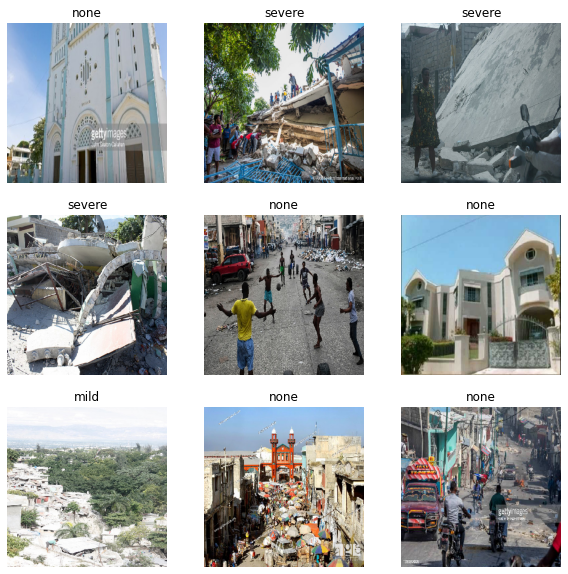

In [45]:
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[int(label)])
    plt.axis("off")

# Model Building

## Create EfficientNet architecture

In [46]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB3

def get_efficient_model(lr=0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")
    pre_trained_model = EfficientNetB3(include_top=False,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = pre_trained_model(x,training= False)
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    efficient_model = models.Model(inputs,outputs)
    efficient_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    efficient_model.summary()
    
    return efficient_model

efficientnet_model = get_efficient_model(lr=1e-3)

lr in model = 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 10,788,146
Trainable params

In [47]:
def subplot_learning_curve(model_name,history):
    #plt.clf()
    plt.figure(figsize=(20,5))
    for i,metric in enumerate(['acc','loss']):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend((metric, 'val_' + metric))
        plt.title(model_name + ": Learning curve " + metric + " vs " + 'val_' + metric)
    plt.show()

In [48]:
output_path = os.path.join(cwd,"outputs","model")
print(output_path)

c:\Users\wsn8\Code\disaster-damage-assessment-ml\outputs\model


# Model Training

### EfficientNet

output: c:\Users\wsn8\Code\disaster-damage-assessment-ml\outputs\model

Training..................
Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 0.9218 - acc: 0.5630

C:\Users\wsn8\AppData\Local\conda\conda\envs\disaster-damage-assessment\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


11/11 [==============================] - 68s 6s/step - loss: 0.9218 - acc: 0.5630 - val_loss: 0.7950 - val_acc: 0.6000
Epoch 2/10
11/11 [==============================] - 56s 5s/step - loss: 0.6211 - acc: 0.7683 - val_loss: 0.6590 - val_acc: 0.7200
Epoch 3/10
11/11 [==============================] - 61s 6s/step - loss: 0.4710 - acc: 0.8651 - val_loss: 0.5822 - val_acc: 0.7600
Epoch 4/10
11/11 [==============================] - 61s 6s/step - loss: 0.4509 - acc: 0.8768 - val_loss: 0.5402 - val_acc: 0.7733
Epoch 5/10
11/11 [==============================] - 62s 6s/step - loss: 0.3765 - acc: 0.8974 - val_loss: 0.4953 - val_acc: 0.7733
Epoch 6/10
11/11 [==============================] - 61s 6s/step - loss: 0.3380 - acc: 0.9179 - val_loss: 0.4670 - val_acc: 0.8267
Epoch 7/10
11/11 [==============================] - 60s 6s/step - loss: 0.2990 - acc: 0.9355 - val_loss: 0.4531 - val_acc: 0.8267
Epoch 8/10
11/11 [==============================] - 59s 6s/step - loss: 0.2811 - acc: 0.9485 - val_lo

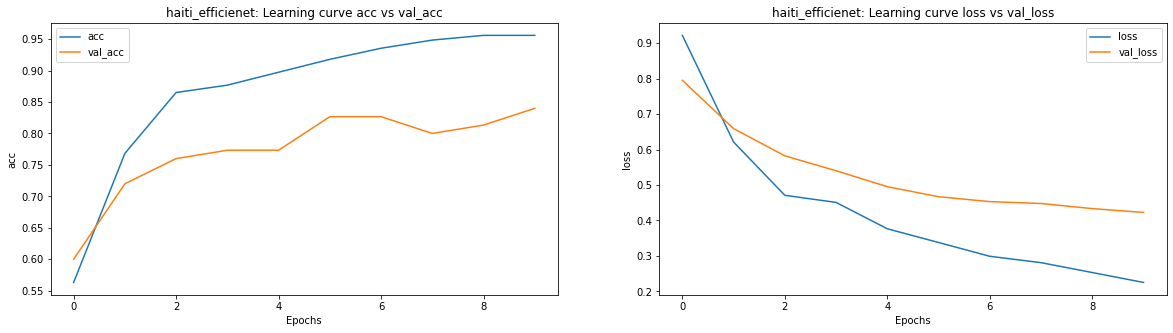

In [49]:
output_path = os.path.join(cwd,'outputs','model')
print("output:",output_path)
exp_name = 'haiti_efficientnet'
n_epochs = 10

check = callbacks.ModelCheckpoint(f'{output_path}/{exp_name}.h5',save_best_only=True)
early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=5,restore_best_weights=True)

print()
print("Training..................")
history = efficientnet_model.fit(train_dataset,
                epochs=n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=valid_dataset,
                validation_steps = validation_steps,
                callbacks=[check,early_stop])

subplot_learning_curve("haiti_efficienet",history)

# Model Evaluation

## Training, Validation and Testing accuracy

In [50]:
results_train = efficientnet_model.evaluate(train_dataset, steps=steps_per_epoch, return_dict=True)
results_train

11/11 [==============================] - 51s 5s/step - loss: 0.2182 - acc: 0.9531


{'loss': 0.2182031273841858, 'acc': 0.9530791640281677}

In [51]:
results_valid = efficientnet_model.evaluate(valid_dataset, steps=validation_steps, return_dict=True)
results_valid

3/3 [==============================] - 13s 6s/step - loss: 0.4227 - acc: 0.8400


{'loss': 0.4226630926132202, 'acc': 0.8399999737739563}

In [52]:
pd.DataFrame(data={'train':results_train,'valid':results_valid}).T

,loss,acc
train,0.218203,0.953079
valid,0.422663,0.840000


## Visualize predictions

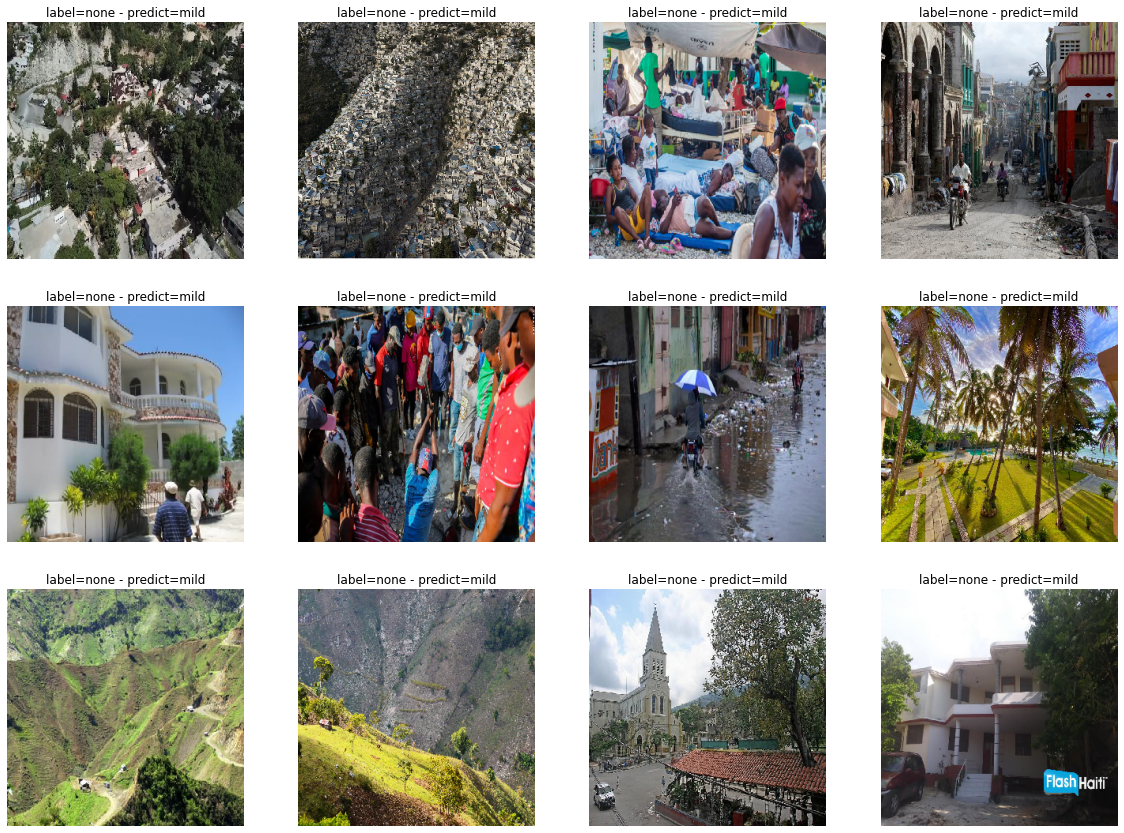

In [54]:
import numpy as np
image_batch, label_batch = next(iter(valid_dataset))


plt.figure(figsize = (20, 20))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i])
    true_label = label_batch[i]
    img = np.asarray(tf.cast(image_batch[i], dtype=tf.float32)) * 1 / 255.0
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.expand_dims(img, axis=0)
    preds = efficientnet_model.predict(img)
    label = np.argmax(preds,axis=-1)
    title = f"label={class_names[int(true_label)]} - predict={class_names[int(label)]}"
    plt.title(title)
    plt.axis("off")
    